In [ ]:
!pip install nes-py==0.2.6
!pip install gym-super-mario-bros
!apt-get update
!apt-get install ffmpeg libsm6 libxext6  -y
!apt install -y libgl1-mesa-glx
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 75 kB 3.6 MB/s 
     |████████████████████████████████| 21.8 MB 1.2 MB/s 
  Created wheel for nes-py: filename=nes_py-0.2.6-cp37-cp37m-linux_x86_64.whl size=168663 sha256=09db1f373d0e408b31006fbf9b6eea2c86ea3f1ab8b8272cac085bbc69a007cd
  Stored in directory: /root/.cache/pip/wheels/cf/87/a9/d777bc0614683325afc2501fe16a01ae29a9bf6c5650cffbad
Successfully built nes-py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 8.4 MB/s 
     |████████████████████████████████| 77 kB 7.1 MB/s 
  Created wheel for nes-py: filename=nes_py-8.2.1-cp37-cp37m-linux_x86_64.whl size=437983 sha256=c8f83962a4799a71cec554573f7bf6f06025be57c3cf584d98be8ddc2f5bbd50
  Stored in directory: /root/.cache/pip/wheels/17/96/0e/22a8c7dbdf412d8e988286f223b223baf0f4ad90c9e699c56d
Successfull

#Importing Libraries/Modules
####Pickling
is the process whereby a Python object hierarchy is converted into a byte stream, and “unpickling” is the inverse operation, whereby a byte stream (from a binary file or bytes-like object) is converted back into an object hierarchy.
####Collection
The collection Module in Python provides different types of containers. A Container is an object that is used to store different objects and provide a way to access the contained objects and iterate over them.
####cv2
It is used to capture video using OpenCV.
####OpenCV
It is a library of programming functions mainly aimed at real-time computer vision.

In [ ]:
import torch
import torch.nn as nn
import random
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from tqdm import tqdm
import pickle 
from gym_super_mario_bros.actions import RIGHT_ONLY
import gym
import numpy as np
import collections 
import cv2
import matplotlib.pyplot as plt

#Creating the environment
Training the agent over the complete frame is not efficient. We can instead skip some of the frames without loss of any information. Then we will downsample each frame to 84x84 image, for efficient calculations. Since training the agent is time consuming over CPU, we will instead convert the image to PyTorch Tensors to train the agent over GPU. Finally we will normalize each pixel in the frame to 0 to 1.


---


env.step() : This command will take an action at each step. The action is specified as its parameter. Env.step function returns four parameters, namely observation, reward, done and info. 
####Max Pooling
Max Pooling is a convolution process where the Kernel extracts the maximum value of the area it convolves(*). Max Pooling simply says to the Convolutional Neural Network that we will carry forward only that information, if that is the largest information available amplitude wise.
Pooling mainly helps in extracting sharp and smooth features. It is also done to reduce variance and computations.
On the other hand, it takes the maximum of every pixel in the last two frames and using it as an observation. 

In [ ]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init to first obs"""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class ProcessFrame84(gym.ObservationWrapper):
    """
    Downsamples image to 84x84
    Greyscales image

    Returns numpy array
    """
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 240 * 256 * 3:
            img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114         ##RGB, For greyscaling
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)        ##interpolation=cv2.INTER_AREA is used to shrink the image
        x_t = resized_screen[18:102, :]                                                  
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape                     ## This observation_space is from gym
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]),
                                                dtype=np.float32)    
                                                                     ## PyTorch- color channel is written first(1, 84, 84)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    """Normalize pixel values in frame --> 0 to 1"""
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)  

    def reset(self):                                                                                  
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)  
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer

def make_env(env):
  #Calling constructors of various classes, basically creating an object
    env = MaxAndSkipEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = ScaledFloatFrame(env)
    return JoypadSpace(env, RIGHT_ONLY)

#Double Deep Q-Network Solver:
We will train the network using convolutional neural networks. 

Sequential is a construction which is used when you want to run certain layers sequentially.
####ReLU:
Rectified Linear Unit
non-linear activation function
f(x)=max(0,x)
####load_state_dict:
Loads a model’s parameter dictionary using a deserialized state_dict.
####Adam Optimizer:
Adam optimizeer involves the combination of two gradient descent methodologies.
####Pickling:
The python object hierarchy is converted to a byte stream- serialization
####Serialization:
Process of converting data object into format that allows us to store and transmit data and then recreate the object when  needed by the process of deserialization
####Unpickling:
Inverse of pickling- deserialization
####torch.load:
Uses pickle's unpickling facilities to deserialize pickled object files to memory.
.pt for checkpointing models in pickle format


---


A PKL file is a file created by pickle, a Python module that enables objects to be serialized to files on disk and deserialized back into the program at runtime. 

---


"rb" mode opens the file in binary format for reading, while the "wb" mode opens the file in binary format for writing. Unlike text files, binary files are not human-readable.

In [ ]:
class DQNSolver(nn.Module):

    def __init__(self, input_shape, n_actions):
        super(DQNSolver, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))          ##np.prod()  returns the product of elements over the given axis

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)
    

class DQNAgent:

    def __init__(self, state_space, action_space, max_memory_size, batch_size, gamma, lr,
                 dropout, exploration_max, exploration_min, exploration_decay, double_dq, pretrained):

        # Define DQN Layers
        self.state_space = state_space
        self.action_space = action_space
        self.double_dq = double_dq
        self.pretrained = pretrained
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        if self.double_dq:  
            self.local_net = DQNSolver(state_space, action_space).to(self.device)
            self.target_net = DQNSolver(state_space, action_space).to(self.device)
            
            if self.pretrained:
                self.local_net.load_state_dict(torch.load("dq1.pt", map_location=torch.device(self.device)))
                self.target_net.load_state_dict(torch.load("dq2.pt", map_location=torch.device(self.device)))
                    
            self.optimizer = torch.optim.Adam(self.local_net.parameters(), lr=lr)
            self.copy = 5000  # Copy the local model weights into the target network every 5000 steps
            self.step = 0
        else:                                                                                                   
            self.dqn = DQNSolver(state_space, action_space).to(self.device)
            
            if self.pretrained:
                self.dqn.load_state_dict(torch.load("dq.pt", map_location=torch.device(self.device)))
            self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=lr)                                   

        # Create memory
        self.max_memory_size = max_memory_size
        if self.pretrained:
            self.STATE_MEM = torch.load("STATE_MEM.pt")
            self.ACTION_MEM = torch.load("ACTION_MEM.pt")
            self.REWARD_MEM = torch.load("REWARD_MEM.pt")
            self.STATE2_MEM = torch.load("STATE2_MEM.pt")
            self.DONE_MEM = torch.load("DONE_MEM.pt")
            with open("ending_position.pkl", 'rb') as f:
                self.ending_position = pickle.load(f)
            with open("num_in_queue.pkl", 'rb') as f:
                self.num_in_queue = pickle.load(f)
        else:
            self.STATE_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.ACTION_MEM = torch.zeros(max_memory_size, 1)
            self.REWARD_MEM = torch.zeros(max_memory_size, 1)
            self.STATE2_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.DONE_MEM = torch.zeros(max_memory_size, 1)
            self.ending_position = 0
            self.num_in_queue = 0
        
        self.memory_sample_size = batch_size
        
        # Learning parameters
        self.gamma = gamma
        self.l1 = nn.SmoothL1Loss().to(self.device) # Also known as Huber loss
        self.exploration_max = exploration_max
        self.exploration_rate = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay

    def remember(self, state, action, reward, state2, done):
        self.STATE_MEM[self.ending_position] = state.float()
        self.ACTION_MEM[self.ending_position] = action.float()
        self.REWARD_MEM[self.ending_position] = reward.float()
        self.STATE2_MEM[self.ending_position] = state2.float()
        self.DONE_MEM[self.ending_position] = done.float()
        self.ending_position = (self.ending_position + 1) % self.max_memory_size  
        self.num_in_queue = min(self.num_in_queue + 1, self.max_memory_size)       
        
    def recall(self):
        # Randomly sample 'batch size' experiences
        idx = random.choices(range(self.num_in_queue), k=self.memory_sample_size)
        
        STATE = self.STATE_MEM[idx]
        ACTION = self.ACTION_MEM[idx]
        REWARD = self.REWARD_MEM[idx]
        STATE2 = self.STATE2_MEM[idx]
        DONE = self.DONE_MEM[idx]
        
        return STATE, ACTION, REWARD, STATE2, DONE

    def act(self, state):
        # Epsilon-greedy action
        
        if self.double_dq:
            self.step += 1
        if random.random() < self.exploration_rate:  
            return torch.tensor([[random.randrange(self.action_space)]])
        if self.double_dq:
            # Local net is used for the policy
            return torch.argmax(self.local_net(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()    
        else:
            return torch.argmax(self.dqn(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()

    def copy_model(self):
        # Copy local net weights into target net
        
        self.target_net.load_state_dict(self.local_net.state_dict())
    
    def experience_replay(self):
        
        if self.double_dq and self.step % self.copy == 0:
            self.copy_model()

        if self.memory_sample_size > self.num_in_queue:      
            return

        STATE, ACTION, REWARD, STATE2, DONE = self.recall()
        STATE = STATE.to(self.device)
        ACTION = ACTION.to(self.device)
        REWARD = REWARD.to(self.device)
        STATE2 = STATE2.to(self.device)
        DONE = DONE.to(self.device)
        
        self.optimizer.zero_grad()
        if self.double_dq:
            # Double Q-Learning target is Q*(S, A) <- r + γ max_a Q_target(S', a)
            target = REWARD + torch.mul((self.gamma * 
                                        self.target_net(STATE2).max(1).values.unsqueeze(1)), 
                                        1 - DONE)

            current = self.local_net(STATE).gather(1, ACTION.long()) # Local net approximation of Q-value
        else:
            # Q-Learning target is Q*(S, A) <- r + γ max_a Q(S', a) 
            target = REWARD + torch.mul((self.gamma * 
                                        self.dqn(STATE2).max(1).values.unsqueeze(1)), 
                                        1 - DONE)
                
            current = self.dqn(STATE).gather(1, ACTION.long())
        
        loss = self.l1(current, target)
        loss.backward() # Compute gradients
        self.optimizer.step() # Backpropagate error

        self.exploration_rate *= self.exploration_decay
        
        # Makes sure that exploration rate is always at least 'exploration min'
        self.exploration_rate = max(self.exploration_rate, self.exploration_min)

In [ ]:
def vectorize_action(action, action_space):
    """Given a scalar action, return a one-hot encoded action"""
    
    return [0 for _ in range(action)] + [1] + [0 for _ in range(action + 1, action_space)]

In [ ]:
def show_state(env, ep=0, info=""):
    plt.figure(3)
    plt.clf()                                   #clear the current figure
    plt.imshow(env.render(mode='rgb_array'))   
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())                  #used to get the current figure

#Training The Model:


In [ ]:
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = make_env(env)  # Wraps the environment so that frames are grayscale 
observation_space = env.observation_space.shape
action_space = env.action_space.n
agent = DQNAgent(state_space=observation_space,
                 action_space=action_space,
                 max_memory_size=30000,
                 batch_size=32,
                 gamma=0.90,
                 lr=0.00025,
                 dropout=0.0,
                 exploration_max=1.0,
                 exploration_min=0.02,
                 exploration_decay=0.99,double_dq = True,pretrained=False)
    
num_episodes = 2000
env.reset()
total_rewards = []
    
for ep_num in range(num_episodes):
    state = env.reset()
    state = torch.Tensor([state])
    total_reward = 0
    steps = 0
    while True:
        action = agent.act(state)
        steps += 1
            
        state_next, reward, terminal, info = env.step(int(action[0]))
        total_reward += reward
        state_next = torch.Tensor([state_next])
        reward = torch.tensor([reward]).unsqueeze(0)
            
        terminal = torch.tensor([int(terminal)]).unsqueeze(0)
            
        agent.remember(state, action, reward, state_next, terminal)
        agent.experience_replay()
            
        state = state_next
        if terminal:
            break
                
    total_rewards.append(total_reward)
    print("Total reward after episode {} is {}".format(ep_num + 1, total_rewards[-1]))
    
 
with open("ending_position.pkl", "wb") as f:
    pickle.dump(agent.ending_position, f)
with open("num_in_queue.pkl", "wb") as f:
    pickle.dump(agent.num_in_queue, f)
with open("total_rewards.pkl", "wb") as f:
    pickle.dump(total_rewards, f)
  
torch.save(agent.local_net.state_dict(), "dq1.pt")
torch.save(agent.target_net.state_dict(), "dq2.pt")

torch.save(agent.REWARD_MEM, "REWARD_MEM.pt")

env.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


Total reward after episode 1 is 1038.0
Total reward after episode 2 is 637.0
Total reward after episode 3 is 1008.0
Total reward after episode 4 is 250.0
Total reward after episode 5 is 250.0
Total reward after episode 6 is 250.0
Total reward after episode 7 is 251.0
Total reward after episode 8 is 251.0
Total reward after episode 9 is 250.0
Total reward after episode 10 is 250.0
Total reward after episode 11 is 248.0
Total reward after episode 12 is 250.0
Total reward after episode 13 is 251.0
Total reward after episode 14 is 250.0
Total reward after episode 15 is 250.0
Total reward after episode 16 is 250.0
Total reward after episode 17 is 251.0
Total reward after episode 18 is 250.0
Total reward after episode 19 is 250.0
Total reward after episode 20 is 250.0
Total reward after episode 21 is 250.0
Total reward after episode 22 is 246.0
Total reward after episode 23 is 251.0
Total reward after episode 24 is 251.0
Total reward after episode 25 is 250.0
Total reward after episode 26 is

#Plotting The Graph:

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
rewards=[]
with (open("total_rewards.pkl", "rb")) as f:
 rewards=pickle.load(f)

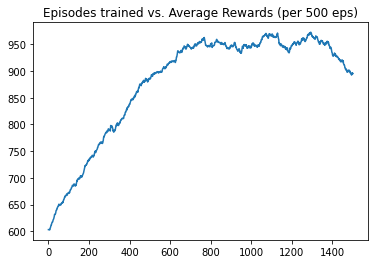

In [ ]:
plt.title("Episodes trained vs. Average Rewards (per 500 eps)")                  
plt.plot(np.convolve(rewards, np.ones((500,))/500, mode="valid").tolist())
plt.show()